In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import torch
import torch.nn as nn
import torch.autograd as ag

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


### Circuit model

In [2]:
## ODE as loss function. Thus would use the network which we call as x_theta
def f(N, t, net, lambs):
    J = lambs  # ODE parameters
    x = net(N,t) # the dependent variable x is given by the network based on independent variables N,t
    ## Based on our f = dx/dt + x - W @ g(x), we need du/dx and du/dt
    x_t = torch.autograd.grad(x.sum(), t, create_graph=True)[0]
    pde = tau*x_t + x - J @ torch.tanh(x)
    return pde

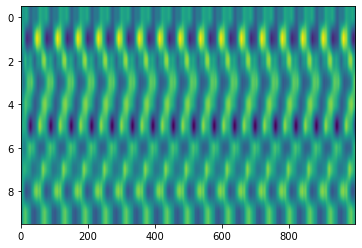

In [3]:
### simple RNN model
N = 10
J = np.random.randn(N,N)*10
vv = np.random.randn(N,2)
J = J + (vv @ vv.T)
T = 100
dt = 0.1
time = np.arange(0,T,dt)
lt = len(time)
xs = np.zeros((N,lt))
x_init = np.random.randn(N)
xs[:,0] = x_init
for tt in range(lt-1):
    xs[:,tt+1] = xs[:,tt] + dt*(-xs[:,tt] + J @ np.tanh(xs[:,tt]))

plt.imshow(xs, aspect='auto')

### Neural dynamics model

In [ ]:
# https://github.com/aaryadevg/PytorchPINN/blob/master/PINN_logistic_eqn.ipynb

In [4]:
def differential_equation(t: torch.Tensor) -> torch.Tensor:
    R: float = 1.0
    return R*t*(1-t)

def analytic_solution(x):
    return (-1/3)*(x**3) + 0.5*(x**2) + 1

def nl_ode(t: torch.Tensor) -> torch.Tensor:
    a: float = 0.5
    b: float = 3
    c: float = 8
    return -a*t*(b-t)*(c-t)

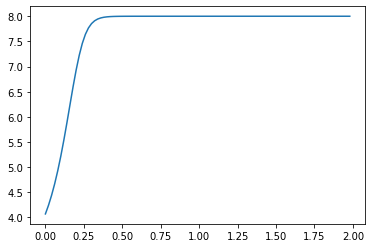

In [5]:
### a simple nonlinear ODE model
a,b,c = 0.5,3,8
T = 2
dt = 0.02
time = np.arange(0,T,dt)
lt = len(time)
xt = np.zeros(lt)
xt[0] = np.random.rand()*10
for tt in range(lt-1):
    xt[tt+1] = xt[tt] + dt*(-a*xt[tt]*(b-xt[tt])*(c-xt[tt]))
plt.plot(time,xt)

In [6]:
def FN_neuron(vw: torch.Tensor, N=2) -> torch.Tensor:
    """
    tensor of NxT dynamical variable
    Here for FN neuron N=2 for v and w variables through time T
    """
    I: float = 0.5
    a: float = 0.7
    b: float = 0.8
    phi: float = 0.08
#     vw = vw.reshape(N,int(len(vw)/N))
    v = vw[:,0]
    w = vw[:,1]
    dvw = torch.ones_like(vw).to(device)
    dvw[:,0] = v - (v**3)/3 - w + I
    dvw[:,1] = (v + a - b*w)*phi
    return dvw#.reshape(-1,1)

In [7]:
test = np.array([[1,2,3],[4,5,6]])
test2 = test.reshape(-1,1)
test2.reshape(2,3)

array([[1, 2, 3],
       [4, 5, 6]])

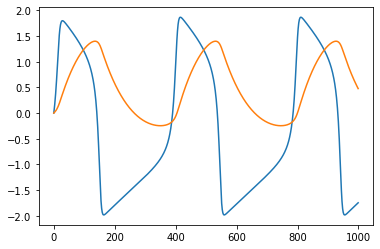

In [8]:
I,a,b = 1.0, 0.9, 0.7
# I,a,b = 1.0116, 0.8287, 0.7095 #1.0331, 0.9531, 0.7187 #2.0000, 1.4373, 0.5627
I,a,b,phi = 0.5,0.7,0.8,0.08
T = 100
dt = 0.1
time = np.arange(0,T,dt)
lt = len(time)
vwt = np.zeros((2,lt))
vw_init = np.random.rand(2)*0.
vwt[:,0] = vw_init
for tt in range(lt-1):
    vwt[0,tt+1] = vwt[0,tt] + dt*(vwt[0,tt] - (vwt[0,tt]**3)/3 - vwt[1,tt] + I)
    vwt[1,tt+1] = vwt[1,tt] + dt*phi*(vwt[0,tt] + a - b*vwt[1,tt])
    
plt.plot(vwt.T)

In [9]:
class ApproximatorNet(nn.Module):
    def __init__(self, input_size: int = 2, output_size: int = 2, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        """
            Builds an neural network to approximate the value of the differential equation
            input_size must be set to number of parameters in the function f for ODE this is 1
            output_size number of values output by the function for ODE this is 1
        """
        super().__init__()
        
        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size) 
        
        self.activation = nn.Tanh() # Can be either tanh or sigmoid, ReLU is not differentiable (at 0)
    
    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
        """
            Runs the input through the hidden layers
        """
        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t

In [10]:
class FHN_neuron_inference(nn.Module):
    def __init__(self):
        super().__init__()
        ### initialize coefficient in the model
        params = torch.tensor([0.5, 0.7, 0.8]) + torch.distributions.Uniform(-0.5, 0.5).sample((3,))
        ### make it into parameter for optimization
        self.params = nn.Parameter(params, requires_grad=True)
        self.N = 2 ### dimensionality
        
    def forward(self, X):
        I,a,b = self.params
        phi = 0.08
        vw = X#.reshape(int(len(X)/self.N),self.N)
        v = vw[:,0]
        w = vw[:,1]
        dvw = torch.ones_like(vw)
        dvw[:,0] = v - (v**3)/3 - w + I
        dvw[:,1] = (v + a - b*w)*phi
        return dvw #.reshape(-1,1)

In [11]:
torch.tensor([1.0, 0.9, 0.7]) + torch.distributions.Uniform(-0.5, 0.5).sample((3,))

tensor([0.6038, 0.7591, 0.9240])

In [12]:
# x = np.linspace(0,10,500)
# y = analytic_solution(x)
# x = time.copy()
# y = xt.copy()
# x = x.reshape(-1,1)
# y = y.reshape(-1,1)
# x_data = x[0:-1:5]
# y_data = y[0:-1:5]

x = time.copy()
y = vwt.copy()

x_data = np.repeat(x[0:-1:50][None,:],2,axis=0).T#.reshape(-1,1)
y_data = y[:,0:-1:50].T#.reshape(-1,1)

x_data_t = torch.tensor(x_data, dtype =torch.float32, device=device)
y_data_t = torch.tensor(y_data, dtype =torch.float32, device=device)

lt_data = 500 #len(x_data)
x_physics = torch.linspace(0, np.max(x), lt_data, requires_grad=True, device=device, dtype=torch.float32).reshape(-1,1)
x_physics = x_physics.repeat(1,2)


In [13]:
y_data.shape

(20, 2)

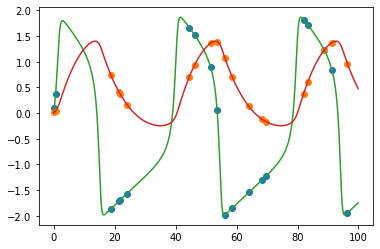

In [14]:
### batch data for training
import random
nbatch = 20
npoints = 20
batches = []
fbatches = []
for i in range(nbatch):
    ids = np.sort(np.random.randint(0,len(x), npoints))  #call batch sample
    x_data_i = np.repeat(x[ids][None,:],2,axis=0).T
    y_data_i = y[:,ids].T
    ib = torch.FloatTensor(x_data_i).to(device)
    ib.requires_grad = True
    fb = torch.FloatTensor(y_data_i).to(device)
    fb.requires_grad = True
    batches.append(ib)
    fbatches.append(fb)
    
plt.plot(batches[13].detach().numpy(), fbatches[13].detach().numpy(),'o')
plt.plot(time,vwt.T)

In [15]:
batches[0].shape

torch.Size([20, 2])

In [18]:
y_data.shape

(20, 2)

In [16]:
### PINN naive tests with BATCH! ### (pre-train with batches??)

### hyperparameters
EPOCHS = 3_000
LR = 1e-3

### setup models and optimization methods
model = ApproximatorNet(hidden_layers=5, hidden_nodes=10).to(device)
# lb = np.array([x[0],x[0]])
# ub = np.array([x[-1],x[-1]])
# layers = np.array([2,20,20,20,20,20,20,20,20,2]) #8 hidden layers
# model = Sequentialmodel(layers)
# model.to(device)

# optim_nn = torch.optim.Adam(model.parameters(), lr=LR) 
ode_model = FHN_neuron_inference().to(device)
# optim_ode = torch.optim.Adam(ode_model.parameters(), lr=LR)
params = list(model.parameters()) + list(ode_model.parameters())
# params = model.parameters()
optim = torch.optim.Adam(params, lr=LR)
# optim = torch.optim.Adam(model.parameters(), lr=LR)

data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    for batch in range(len(batches)):
        batch_index = batch #np.random.randint(0,m)
        x_data_t = batches[batch_index]
        y_data_t = fbatches[batch_index]
        
        
        optim.zero_grad()

        ### Data loss
        y_pred = model(x_data_t)#(np.repeat(x_data_t,2,1))
        loss_u = data_loss(y_pred, y_data_t)

        ### Physics loss
        x_physics = x_data_t.clone()
        u = model(x_physics)
        du = ag.grad(u, x_physics, torch.ones_like(u).to(device), create_graph=True)[0]

        biophysics = du - ode_model(u)  # FHN class imported above
#         biophysics = du - FN_neuron(x_physics)  # the function with fixed parameter
#         biophysics = du - differential_equation(x_physics)  # original logisitic function
#         biophysics = du - nl_ode(x_physics)  # some other bistable nonlinear ODE
#         loss_f = torch.mean(biophysics**2)
        loss_f = data_loss(du , ode_model(u))
#         loss_init = torch.mean((u[0]-y_data_t[0])**2) #initial condition for ode
    
        ### loss for physics-informed neural-network
        loss = 1*loss_u + loss_f# + loss_init
        loss.backward(retain_graph=True)
        optim.step()

        ### constraints for optimization
#         with torch.no_grad():
#             for param in ode_model.parameters():
#                 param.clamp_(0, 2)

    ### print progress
    if (epoch % 500 == 0):# and batch % 10 == 0):
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.7f}", 'nn loss %f, f loss %f'%(float(loss_u), float(loss_f)) )


Epochs = 0 of 3000, Loss = 1.2469906 nn loss 1.246893, f loss 0.000098


KeyboardInterrupt: 

In [301]:
### PINN naive tests ###

### hyperparameters
EPOCHS = 20_000
LR = 1e-3

### setup models and optimization methods
model = ApproximatorNet(hidden_layers=5, hidden_nodes=20).to(device)
# lb = np.array([x[0],x[0]])
# ub = np.array([x[-1],x[-1]])
# layers = np.array([2,20,20,20,20,20,20,20,20,2]) #8 hidden layers
# model = Sequentialmodel(layers)
# model.to(device)

# optim_nn = torch.optim.Adam(model.parameters(), lr=LR) 
ode_model = FHN_neuron_inference().to(device)
# optim_ode = torch.optim.Adam(ode_model.parameters(), lr=LR)
params = list(model.parameters()) + list(ode_model.parameters())
# params = model.parameters()

optim = torch.optim.Adam(params, lr=LR)
# optim = torch.optim.Adam(model.parameters(), lr=LR)
# optim_ode = torch.optim.Adam(ode_model.parameters(), lr=LR)

data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    optim.zero_grad()

    ### Data loss
    y_pred = model(x_data_t)#(np.repeat(x_data_t,2,1))
    loss_u = torch.mean((y_pred - y_data_t)**2)  #data_loss(y_pred, y_data_t)

    ### Physics loss
    u = model(x_physics)
#     xph_dumb = x_physics.clone()
    #torch.cat((x_physics,x_physics),1).requires_grad_().to(device)#, requires_grad=True, device=device, dtype=torch.float32)
#     du1 = ag.grad(u[:,0], x_physics[:,0], torch.ones_like(u[:,0]).to(device), create_graph=True)[0]
#     du2 = ag.grad(u[:,1], x_physics[:,1], torch.ones_like(u[:,1]).to(device), create_graph=True)[0]
#     du = torch.cat((du1,du2),1)
    du = ag.grad(u, x_physics, torch.ones_like(u).to(device), create_graph=True)[0]

    biophysics = du - ode_model(u)  # FHN class imported above
#     biophysics = du - FN_neuron(u)  # the function with fixed parameter
#     biophysics = du - differential_equation(x_physics)  # original logisitic function
#     biophysics = du - nl_ode(x_physics)  # some other bistable nonlinear ODE
    loss_f = torch.mean(biophysics**2)
#     loss_f = data_loss(du , ode_model(x_physics))
    loss_init = torch.mean((u[0]-y_data_t[0])**2) #initial condition for ode
    
    ### loss for physics-informed neural-network
    loss = 1*loss_u + 1*loss_f + loss_init
    loss.backward(retain_graph=True)
    optim.step()
#     loss1 = loss_u.clone()
#     loss1.backward()
#     loss2 = loss_f.clone()
#     loss2.backward()
#     optim.step()
#     optim_ode.step()
    
    ### constraints for optimization
#     with torch.no_grad():
#         for param in ode_model.parameters():
#             param.clamp_(0, 2)
    
    ### print progress
    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.7f}, loss_u={float(loss_u):.5f}, loss_f={float(loss_f):.5f}")
        print('current param estimation:', ode_model.params)

Epochs = 0 of 20000, Loss = 3.3724084, loss_u=1.51570, loss_f=0.00031
current param estimation: Parameter containing:
tensor([0.1865, 0.1999, 0.3388], requires_grad=True)
Epochs = 1000 of 20000, Loss = 0.5245764, loss_u=0.46083, loss_f=0.06049
current param estimation: Parameter containing:
tensor([0.5267, 0.4274, 0.6270], requires_grad=True)
Epochs = 2000 of 20000, Loss = 0.0946173, loss_u=0.03546, loss_f=0.05862
current param estimation: Parameter containing:
tensor([0.4903, 0.2266, 1.1794], requires_grad=True)
Epochs = 3000 of 20000, Loss = 0.0059711, loss_u=0.00358, loss_f=0.00238
current param estimation: Parameter containing:
tensor([0.5122, 0.2882, 1.0258], requires_grad=True)
Epochs = 4000 of 20000, Loss = 0.0034743, loss_u=0.00216, loss_f=0.00131
current param estimation: Parameter containing:
tensor([0.5207, 0.2687, 0.9205], requires_grad=True)
Epochs = 5000 of 20000, Loss = 0.0041001, loss_u=0.00229, loss_f=0.00180
current param estimation: Parameter containing:
tensor([0.51

In [302]:
uu.shape

torch.Size([500, 2])

In [262]:
### note ... the functional loss is weird!)

In [323]:
print('true parameters I,a,b,phi=',str(np.array([0.5, 0.7, 0.8,0.08])))
ode_model.params

true parameters I,a,b,phi= [0.5  0.7  0.8  0.08]


Parameter containing:
tensor([0.5355, 0.5671, 0.7970], requires_grad=True)

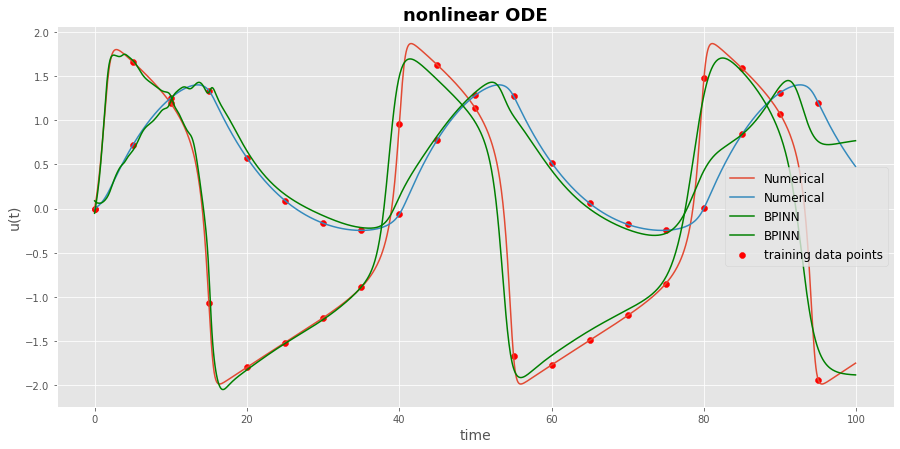

In [324]:
model.eval()
# y_pred = model(torch.tensor(x, dtype = torch.float32, device=device).reshape(-1,1))
y_pred = model(torch.tensor(x, dtype = torch.float32, device=device).repeat(2,1).T)
y_pred = y_pred.detach().cpu().numpy()#.reshape(-1,)

title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
} 

plt.figure(figsize=(15, 7))
plt.style.use("ggplot")
# plt.xticks(np.arange(0, 1.01, step=0.1))
plt.title("nonlinear ODE", title_font)
plt.plot(x, y.T, label="Numerical")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="BPINN", c="g")
plt.ylabel("u(t)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="training data points")
# plt.scatter(np.repeat(x_data,2), y_data, c="r", label="training data points")
plt.legend(fontsize="large")
plt.savefig("1st-Order-ODE.svg")
plt.show()

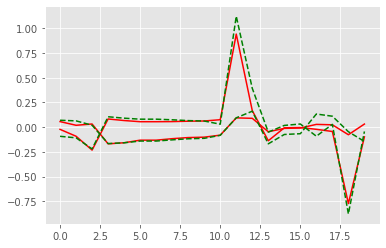

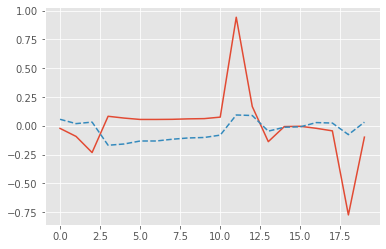

In [325]:
### plot du and model-based du
#ode_model = FHN_neuron_inference().to(device)
u = model(x_physics)
du = ag.grad(u, x_physics, torch.ones_like(u).to(device), create_graph=True)[0]
biophysics = du - ode_model(u)  # FHN class imported above
loss_f = data_loss(du , ode_model(x_physics))
loss_f
aa = du.detach().numpy()
bb = ode_model(u).detach().numpy()
# plt.plot(aa,bb,'o',alpha=0.5)
np.mean((aa-bb)**2)
plt.plot(aa,'r')
plt.plot(bb,'g--')

plt.figure()
plt.plot(aa[:,0])
plt.plot(aa[:,1],'--')

0.03224156

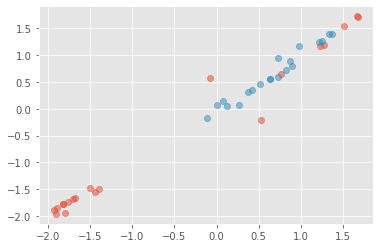

In [326]:
### plot u and constructed u
u = model(x_data_t)
aa = u.detach().numpy()
bb = y_data_t.detach().numpy()
plt.plot(aa,bb,'o',alpha=0.5)
np.mean((aa-bb)**2)

In [178]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

### Try to compare this with simple optimization with only ODE form